# Recommendations with IBM
## 4. Content Based Recommendation
This notebook is the fourth one in the Recommendations with IBM project. In this notebook I created a recommendation function based on similarities between items. I used IBM data set for this project. In order to be able to make a content based recommendations, we need information about the contents of the article. However, in the data set we have title, description and body but do not have specific conent infromation. Therefore, first i extracted content domains from descriptions of the article and then used them to make recommendations.


This process was conducted in 3 steps: 

1. Creating content domain information
2. Finding similar items
3. Recommending articles

The detailed infromation regarding the data sets can be found in the first notebook: Exploratory Analysis.   
If you need to make a recommendation to a new user, you can use rank based recommendation explained in the second notebook in this repo.

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np


# Import libraries for text preprocessing
import re
import nltk
import seaborn as sns

# You only need to download these resources once. After you run this 
# the first time--or if you know you already have these installed--
# you can comment these two lines out (with a #)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

C:\Users\Nermin\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nermin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nermin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nermin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#read the data files 1 : user item interaction
df = pd.read_csv('user-item-interactions.csv')
del df['Unnamed: 0']

#to make data look better we converted the emails to user ids.
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [3]:
#read files 2: content information
df_content = pd.read_csv('articles_community.csv')

del df_content['Unnamed: 0']

df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### 1. Creating content domain information
There are multiple ways to create content information. As seen in df_content dataset, there are three columns we could use to understand the content of the article. In this project I used doc_full_name column. 
To have a general understanding, I used NLP in two ways. First, I analayzed word by word to see most common words in the full name. Second I analyzed word-pairs to see most common pairs. Then I used first 30 most common words and pairs to create content domains.

In [33]:
def tokenize(text):
    """ Tokenize given text:
        
        Cleans stop words 
        Lemmatizes the text
    INPUT:
        Text: text string
    OUTPUT:
        Tokens: A list of clean tokens
    """
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return tokens

In [34]:
full_names = list(df_content.doc_full_name)

clean_tokens=[]
for sentence in full_names:
    token=tokenize(sentence)
    clean_tokens.extend(token)

In [51]:
# View most frequently occuring keywords
def get_top_n_words(corpus, n=None):
     '''
    This function gets most frequent n word in the corpus 
    INPUT: 
    corpus= a list of clean tokens
    n=number of words to be reported
    
    OUTPUT:
    words_freq: list of word and frequncy pairs
    '''
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

# Convert most freq words to dataframe for plotting bar plot, save as CSV
top_words = get_top_n_words(clean_tokens, n=30)
top_df = pd.DataFrame(top_words)
top_df.columns=["Keyword", "Frequency"]
#print(top_df)

[Text(0, 0, 'data'),
 Text(0, 0, 'ibm'),
 Text(0, 0, 'science'),
 Text(0, 0, 'compose'),
 Text(0, 0, 'watson'),
 Text(0, 0, 'using'),
 Text(0, 0, 'learning'),
 Text(0, 0, 'cloudant'),
 Text(0, 0, 'lab'),
 Text(0, 0, 'spark'),
 Text(0, 0, 'database'),
 Text(0, 0, 'machine'),
 Text(0, 0, 'week'),
 Text(0, 0, 'postgresql'),
 Text(0, 0, 'python'),
 Text(0, 0, 'apache'),
 Text(0, 0, 'notebook'),
 Text(0, 0, 'part'),
 Text(0, 0, 'dsx'),
 Text(0, 0, 'medium'),
 Text(0, 0, 'dashdb'),
 Text(0, 0, 'use'),
 Text(0, 0, '2016'),
 Text(0, 0, 'mongodb'),
 Text(0, 0, 'first'),
 Text(0, 0, 'simple'),
 Text(0, 0, 'bluemix'),
 Text(0, 0, 'query'),
 Text(0, 0, 'new'),
 Text(0, 0, 'node')]

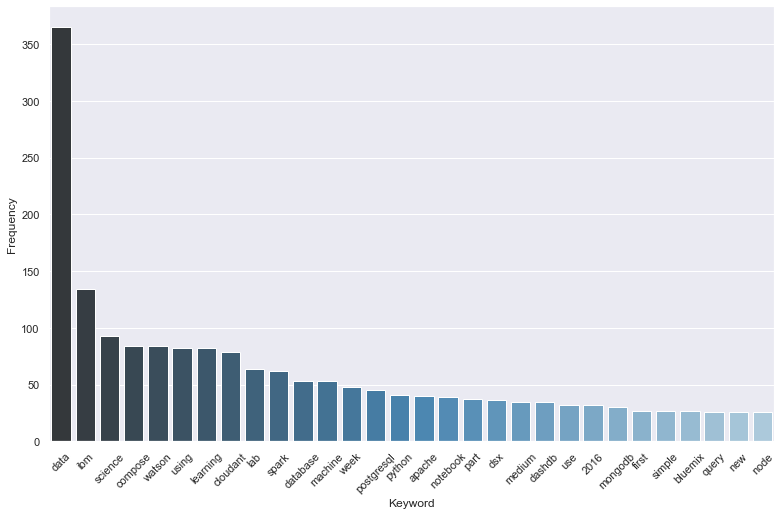

In [39]:
# Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Keyword", y="Frequency", data=top_df, palette="Blues_d")
g.set_xticklabels(g.get_xticklabels(), rotation=45)

In [40]:
def get_top_n2_words(corpus, n=None):
    '''
    This function gets most frequent n word pairs in the corpus 
    INPUT: 
    corpus= a list of sentences
    n=number of words to be reported
    
    OUTPUT:
    words_freq: list of word and frequncy pairs for each word pair
    '''
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]


In [41]:
top2_words = get_top_n2_words(full_names, n=30)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Frequency"]
#print(top2_df)

[Text(0, 0, 'data science'),
 Text(0, 0, 'ibm watson'),
 Text(0, 0, 'watson data'),
 Text(0, 0, 'data lab'),
 Text(0, 0, 'in data'),
 Text(0, 0, 'machine learning'),
 Text(0, 0, 'this week'),
 Text(0, 0, 'week in'),
 Text(0, 0, 'apache spark'),
 Text(0, 0, 'lab medium'),
 Text(0, 0, 'how to'),
 Text(0, 0, 'in dsx'),
 Text(0, 0, 'deep learning'),
 Text(0, 0, 'ibm data'),
 Text(0, 0, 'node js'),
 Text(0, 0, 'offline first'),
 Text(0, 0, 'science experience'),
 Text(0, 0, 'in postgresql'),
 Text(0, 0, 'the most'),
 Text(0, 0, 'started with'),
 Text(0, 0, 'data in'),
 Text(0, 0, 'making the'),
 Text(0, 0, 'most of'),
 Text(0, 0, 'of compose'),
 Text(0, 0, 'datalayer conference'),
 Text(0, 0, 'data with'),
 Text(0, 0, 'jupyter notebooks'),
 Text(0, 0, 'getting started'),
 Text(0, 0, 'data into'),
 Text(0, 0, 'and compose')]

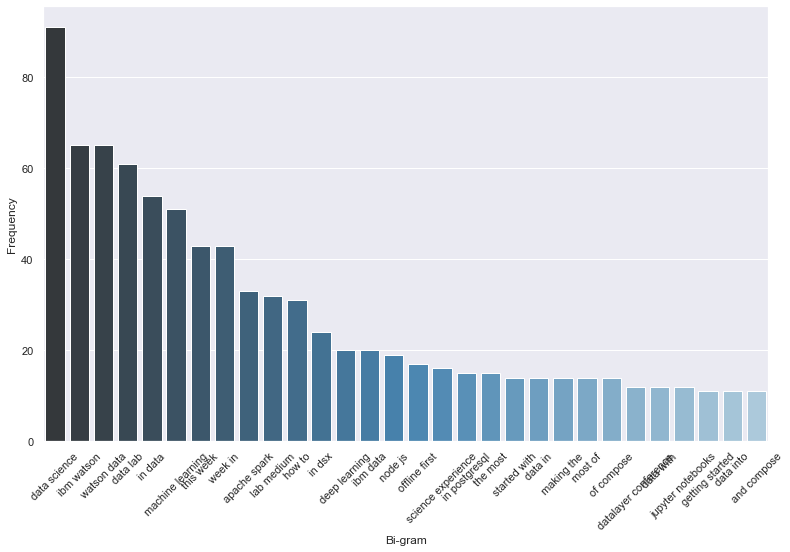

In [18]:
#put it on a bar graph
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Bi-gram", y="Frequency", data=top2_df, palette="Blues_d")
g.set_xticklabels(g.get_xticklabels(), rotation=45)

By the help of the most frequent expressions and some intuition, I created the following content domains. There is no single way to do this step. 

In [42]:
#for each content domain I also created some keywords that may help identifying content domains of the articles
Content_Domains={'Data_Science': ['wrangling','tidyr','tidyverse','tibble','statistics','data science','data analysis','machine learning','database','deep learning','ml'],
                 'Watson_studio': ['watson studio','watson'],
                 'Machine_Learning':['machine learning','sckit','deep learning','classification','ml'],
                 'Spark':['spark','apache'],
                 'Medium_Posts':['medium','medium'],
                 'Database':['watson','warehousing','warehouse','database','SQL','cloud','api','cloudant','postgresql'],
                 'Cloud': ['cloud','api','cloudant','multicloud'],
                 'Python': ['python','python programming','sckit'],
                 'Data_Visualization':['visualizing','visualizations', 'visualization','visualising','visual'] ,
                 'Tutorials': ['tutorials','tutorial']}


In [43]:
def create_content_class(article_id, df=df,Content_Domains=Content_Domains):
    '''This function creates content classes by using title of the articles
    INPUT:
    article id: a float corresponding article id
    df= data frame including article id and article title
    Content_Domains: dictionary keys as content classes and items as keywords
    
    OUTPUT:
    class_df= data frame indicates content classes 0s and 1s and has an index of article id
    '''
    title=df[df['article_id']==article_id]['title'].iloc[0]
    class_dict={'article_id':article_id}
    
    for key in Content_Domains.keys():
        c=0
        for k in Content_Domains[key]:
            if k in title:
                c+=1
                break
        class_dict.update({key:c})
        
    class_df=pd.DataFrame(class_dict,index=[article_id])
    
    return class_df
            

In [44]:
#lest check how function works
create_content_class(article_id=1338.0)

,article_id,Data_Science,Watson_studio,Machine_Learning,Spark,Medium_Posts,Database,Cloud,Python,Data_Visualization,Tutorials
1338.0,1338.0,1,0,1,0,0,0,0,0,0,0


In [45]:
def create_df_class_ranked(df=df):
    '''This function creates a df that includes content domains, number of interactions and article title
    INPUT:
    df: data frame includes user item interactions
    OUTPUT:
    df_articles_class: data frame includes content domains, number of interactions and article title
    '''
    #this line creates a df that each article in df is represented only once
    df_articles=df.groupby('article_id',as_index=False).max()
    
    #this loops over article titles and creates a content domain df
    df_articles_class=create_content_class(article_id=0.0)
    for article in list(df_articles['article_id'])[1:]:
        df_articles_class=pd.concat([df_articles_class,create_content_class(article_id=article)])
    
    
    #this line creates a df consists of two columns: article id and number of interactiosn
    df_interaction= df.groupby('article_id',as_index=False).count()[['article_id','title']].rename(columns={'title': 'num_interaction'})
    
    #this line merges number of interactions with contents
    df_articles_class=pd.merge(df_interaction,df_articles_class,on='article_id')
    
    #this line merges article titles and ranks df by number of interction
    df_articles_class=pd.merge(df_articles[['article_id','title']],df_articles_class,on='article_id').sort_values(by='num_interaction',ascending=False)
    
    return df_articles_class

In [46]:
df_class_ranked=create_df_class_ranked(df=df)
df_class_ranked.head()

,article_id,title,num_interaction,Data_Science,Watson_studio,Machine_Learning,Spark,Medium_Posts,Database,Cloud,Python,Data_Visualization,Tutorials
699,1429.0,use deep learning for image classification,937,1,0,1,0,0,0,0,0,0,0
625,1330.0,insights from new york car accident reports,927,0,0,0,0,0,0,0,0,0,0
701,1431.0,visualize car data with brunel,671,0,0,0,0,0,0,0,0,1,0
697,1427.0,"use xgboost, scikit-learn & ibm watson machine...",643,1,1,1,0,0,1,1,0,0,0
652,1364.0,predicting churn with the spss random tree alg...,627,0,0,0,0,0,0,0,0,0,0


### 2. Finding similar items
In this part I used dot product of item content information to find the similar items.

In [47]:
def find_similar_items(article_id, df=df_class_ranked):
    '''This functions returns a df with a similarity index given an article
    INPUTS:
    article_id: fload
    df_class_ranked: data frame includes content domain info
    
    OUTPUT:
    similarity_df: Data frame having two colums: article id and similarity value
    '''
    item1=df_class_ranked[df_class_ranked['article_id']==article_id].iloc[:,3:]
    items=df_class_ranked.iloc[:,3:]
    similarity= np.concatenate(np.dot(items,item1.T))
    similarity_df=pd.DataFrame(similarity,columns=['similarity'],index=df_class_ranked.index)
    similarity_df=pd.merge(df_class_ranked[['article_id']],similarity_df,left_index=True,right_index=True)
    
    return similarity_df


In [48]:
#lets take a look for similarity
find_similar_items(article_id=1427.0).head()

,article_id,similarity
699,1429.0,2
625,1330.0,0
701,1431.0,0
697,1427.0,5
652,1364.0,0


### 3. Making Recommendations
By using similarity index, we will recommend articles. In this process I used both similarity and number of interactions, meaining how many people interacted with the article. Therefore while recommending similar articles, we will order them by number of interactions.

In [49]:
def make_content_recs(article_id,df=df_class_ranked, n=10):
    '''
    INPUT:
    article_id: a float indicationg article id
    df_class_ranked: data frame includes article id, title, number of interactions and content domains
    n: integer, number of recommendations default is 10
    OUTPUT:
    recs: a list of article titles that we recommend
    '''
    #find similarity
    similarity=find_similar_items(article_id=article_id,df=df)
    
    #create a df consists of article id, title, number of interactions and similarity
    recs_df=pd.merge(df_class_ranked[['article_id','title','num_interaction']],similarity, on='article_id').sort_values(by=['similarity','num_interaction'],ascending=False)
    recs=list(recs_df.title[1:(n+1)])
    
    return recs

In [50]:
# make a recommendations for a user who only has interacted with article id 1427.0
make_content_recs(1427.0)


['from local spark mllib model to cloud with watson machine learning',
 'rapidly build machine learning flows with dsx',
 'watson machine learning for developers',
 'from scikit-learn model to cloud with wml client',
 'apple, ibm add machine learning to partnership with watson-core ml coupling',
 '0 to life-changing app: new apache systemml api on spark shell',
 '3 scenarios for machine learning on multicloud',
 'ibm watson machine learning: get started',
 'create a project for watson machine learning in dsx',
 'style transfer experiments with watson machine learning']